In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata
import scprep
from sklearn.decomposition import TruncatedSVD
import torch
sc.settings.verbosity = 3    

### Load the data, transport to have row as cells and columns as genes

In [3]:
with open("GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv") as data:
    adata = anndata.read_csv(data, delimiter='\t')
adata=adata.T

In [5]:
adata.var

""
A1BG-AS1
A2M
A2M-AS1
A2ML1
A2ML1-AS1
...
ZZZ3
bP-21201H5.1
bP-21264C1.2
bP-2189O9.2


### Find the highest expressed gene 

normalizing counts per cell
    finished (0:00:00)


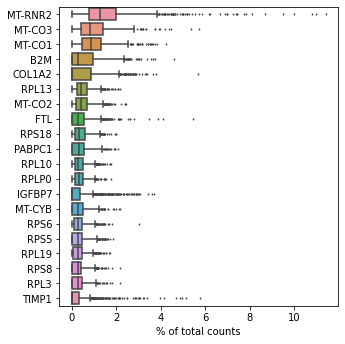

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Normalized each cell so every cell have the same counts

In [7]:
sc.pp.normalize_total(adata, target_sum=1e6)

normalizing counts per cell
    finished (0:00:00)


### log1p transform, escape the scaling

In [6]:
sc.pp.log1p(adata)

In [10]:
#sc.pp.scale(adata, max_value=10)

### Add the annotation of cell types and make them into obs and obsm

In [13]:
anno=pd.read_csv("SNAREseq_types2.txt",header=None)

In [10]:
adata.obs['cell_type']=np.asanyarray(anno)

In [11]:
adata.obsm['cell_type']=np.asanyarray(anno)

In [14]:
adata.obs

,cell_type
ACTTTCTAATCA,2
GAGAGAAAACCT,3
TACGGCTGTTAT,3
GACGCGTAAGTG,2
GAAAGGACTGCA,2
...,...
GTTCTTCCTAGT,1
ATCCGTTCAACG,1
CCGACTAAGAAT,3
AAGCCTGGGGGC,1


In [15]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:03)


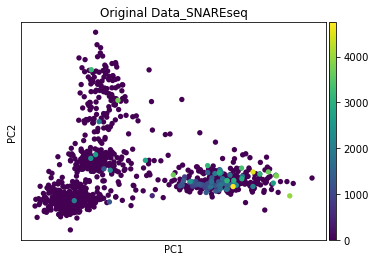

In [16]:
#sc.pl.pca(adata, color='CST3',components = ['1,2','3,4','5,6','7,8'],ncols=2)
sc.pl.pca(adata, color='CST3',title='Original Data_SNAREseq')

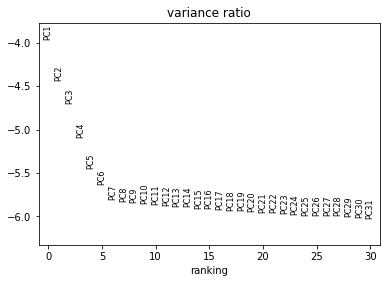

In [17]:
sc.pl.pca_variance_ratio(adata, log=True)

### Find neighbors

In [26]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=45)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


### Calculate Umaps

In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


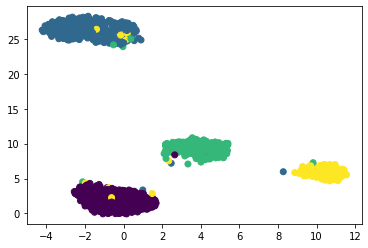

In [28]:
labels=anno
plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=labels)
plt.show()

In [30]:
#sc.pl.umap(adata, color='CST3',  title="UMAP")

In [31]:
adata.obsm['X_umap'].shape

(1047, 2)

In [32]:
adata.obsm['X_umap'][1000]

array([0.8299214, 1.9831951], dtype=float32)

In [24]:
#sc.tl.dendrogram(adata,groupby = "leiden_1.0")

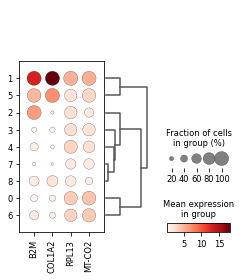

In [78]:
#genes  = ["B2M","COL1A2","RPL13","MT-CO2"]
#sc.pl.dotplot(adata, genes, groupby='leiden_1.0', dendrogram=True)

In [33]:
adata.var_names

Index(['A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A4GALT', 'AAAS',
       'AACS', 'AACSP1', 'AADACL2-AS1',
       ...
       'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3', 'bP-21201H5.1',
       'bP-21264C1.2', 'bP-2189O9.2', 'bP-2189O9.3'],
      dtype='object', length=18666)

# Autoencoder Output

### Read in the autoencoder outpout matrix and transfer into anndata

In [34]:
auto_data=torch.load("pred.pt", map_location=torch.device('cpu'))[0]
auto_data=auto_data['train'].numpy()
print(auto_data.shape)

(1047, 50)


In [38]:
auto_data=anndata.AnnData(auto_data)

### Add the cell type labels

In [39]:
auto_data.X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.02837   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 12.352412  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.20377097,
         0.        ,  9.784126  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.1602996 ,
         0.        ,  1.8635658 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.88969535,
         0.        ,  2.7898622 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.5144834 ,
         0.        ,  2.6734667 ]], dtype=float32)

In [40]:
auto_data.obs['cell_type']=np.asanyarray(anno)

In [41]:
auto_data.obsm['cell_type']=np.asanyarray(anno)

In [42]:
auto_data.obsm['cell_type']

array([[2],
       [3],
       [3],
       ...,
       [3],
       [1],
       [1]])

In [45]:
#sc.tl.pca(auto_data, svd_solver='arpack')

computing PCA
    with n_comps=49
    finished (0:00:00)


In [46]:
#sc.tl.pca(auto_data, svd_solver='arpack',n_comps=15)

computing PCA
    with n_comps=15
    finished (0:00:00)


In [49]:
sc.pp.neighbors(auto_data, n_neighbors=15, n_pcs=15)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [ ]:
# sc.tl.umap(auto_data)

### auto_data.obsm['X_umap'] has 1047 pairs of points (x,y)

In [54]:
auto_data.obsm['X_umap']

array([[-0.6792345, -1.9862556],
       [10.652844 ,  5.567401 ],
       [ 1.6930357, 11.96992  ],
       ...,
       [ 1.0284675,  5.2795153],
       [ 7.019168 , 16.08533  ],
       [ 6.2677884, 15.242341 ]], dtype=float32)

In [55]:
auto_data.obsm['X_umap'][:,0]

array([-0.6792345, 10.652844 ,  1.6930357, ...,  1.0284675,  7.019168 ,
        6.2677884], dtype=float32)

In [56]:
auto_data.obsm['X_umap'][:,1]

array([-1.9862556,  5.567401 , 11.96992  , ...,  5.2795153, 16.08533  ,
       15.242341 ], dtype=float32)

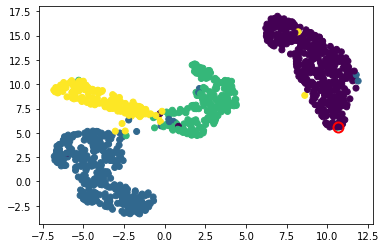

In [57]:
labels=anno
plt.scatter(auto_data.obsm['X_umap'][:,0],auto_data.obsm['X_umap'][:,1],c=labels)
plt.plot(10.652844,5.567401, 'o',
   ms=10, mec="red", mfc='none', mew=2)
plt.show()

In [58]:
np.argmax(adata.X[1])

9154

In [59]:
adata.X[1,9154]=0

In [86]:
print(adata.X[1,9154])

0.0
